# PDAC (Visium) Analysis Tutorial

<p style="color:#1E90FF;">
<b>Data availability:</b> All processed spatial transcriptomics datasets are publicly available on Zenodo:
<a href="https://doi.org/10.5281/zenodo.17522268" style="color:#1E90FF; text-decoration:underline;">
https://doi.org/10.5281/zenodo.17522268
</a>
</p>

In [1]:
from models.SCILD_main import *
from models.help_func import create_LRDatabase_D, compute_spatial_autocorrelation
import scanpy as sc
import squidpy as sq
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

## Import data

In [2]:
adata = sc.read_h5ad('./data/PDACVisium_adata_processed.h5ad') 
adata

AnnData object with n_obs × n_vars = 407 × 12233
    obs: 'cell_type', 'x', 'y', 'pseudotime'
    obsm: 'spatial'

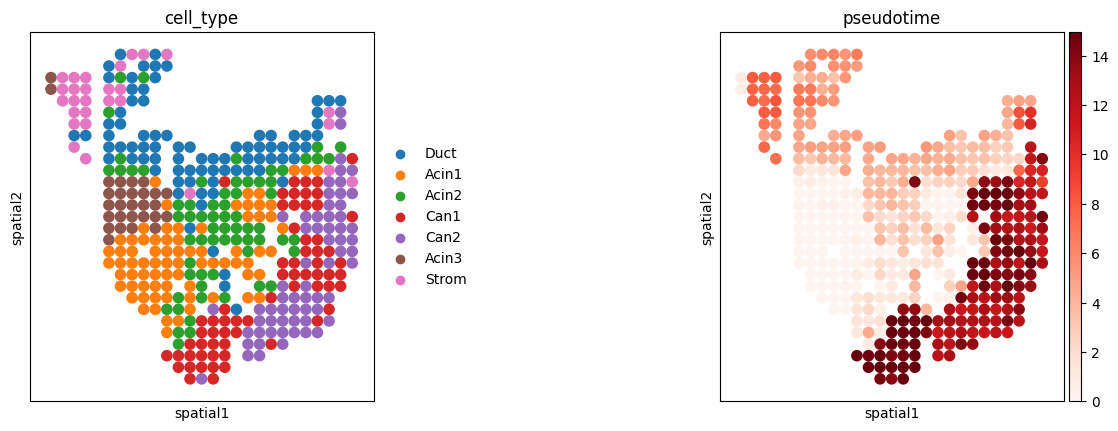

In [3]:
sc.pl.spatial(adata, spot_size=1, color=['cell_type', 'pseudotime'], cmap='Reds', img_key=None)

## Create L-R database

In [4]:
LRDatabase_D = create_LRDatabase_D(
    adata,
    min_cell_pct=0.01,
    database='CellChat',
    species='human'
)

In [5]:
LRDatabase_D.shape

(79, 89)

## Run SCILD

In [6]:
CCCProb = SCILD(adata=adata,
                LRDatabase_D=LRDatabase_D,
                neighbor_k=10,
                alpha_q=0.1,
                alpha_f=0.1,
                alpha_g=0.1,
                niter_max=100,
                eps=1e-4,
                verbose=True,
                plot_error=True
                )
CCCProb.preparing()
nl = CCCProb.nl
nr = CCCProb.nr
ns = CCCProb.ns
print('The number of ligand is: ' + str(nl))
print('The number of receptor is: ' + str(nr))
print('The number of spot is: ' + str(ns))

*************Preparing*************
neighbor_k: 10
The number of ligand is: 79
The number of receptor is: 89
The number of spot is: 407



*************Solving*************
The relative error is: 0.058004451698622825
The relative error is: 0.027934945967709863
The relative error is: 0.019728016506515886
The relative error is: 0.015515203748926048
The relative error is: 0.012907227665545973
The relative error is: 0.01111295752948354
The relative error is: 0.00979349590742492
The relative error is: 0.00877700435538612
The relative error is: 0.007965049989576783
The relative error is: 0.007300575795699182

 The final relative error is: 0.007300575795699182
The total iteration step is: 100


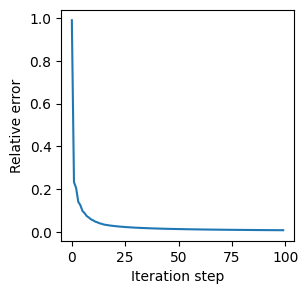

In [7]:
mu0 = np.random.random(nl * ns).reshape(-1, 1)
v0 = np.random.random(nr * ns).reshape(-1, 1)
CCCProb.solving_optimization(mu0, v0)

In [8]:
CCCProb.adata

AnnData object with n_obs × n_vars = 407 × 12233
    obs: 'cell_type', 'x', 'y', 'pseudotime'
    uns: 'cell_type_colors'
    obsm: 'spatial', 'sum-sender-Q', 'sum-sender-P', 'sum-receiver'

## Extract LR CCC

In [9]:
CCCProb.query_all_LR()

In [10]:
CCCProb.tensor_P.shape

(407, 407, 79, 89)

In [11]:
res_dict = tensor_to_method_result(CCCProb.tensor_P, 
                                   list(CCCProb.LRDatabase_D.index), 
                                   list(CCCProb.LRDatabase_D.columns))
len(res_dict)

7031

In [12]:
res_dict = filter_method_result_by_LR_database(res_dict, CCCProb.LRDatabase_D)
len(res_dict)

232

In [13]:
import pickle
with open("./results/PDACVisium_SCILD_result.pkl", "wb") as f:
    pickle.dump(res_dict, f)

## Visualization

select L-Rs to show (spatial)

In [14]:
CCC_df = CCCProb.compute_TSSR()
CCC_adata = sc.AnnData(CCC_df)
CCC_adata.obsm['spatial'] = adata.obsm['spatial']
CCC_adata

AnnData object with n_obs × n_vars = 407 × 464
    obsm: 'spatial'

In [15]:
LR_df_spatial = compute_spatial_autocorrelation(CCC_adata)
LR_df_spatial.sort_values('moran_I', ascending=False).head()

,moran_I,p_value
PRSS2->F2RL2 (S),0.783378,1.689743e-300
PRSS2->F2RL3 (S),0.727438,1.550579e-259
C3->C3AR1 (S),0.696327,4.632171e-238
MIF->CD74 (R),0.653261,7.115969e-210
PRSS2->F2R (S),0.629757,3.026106e-195


In [16]:
CCCProb.adata.obs[CCC_df.columns] = CCC_df
CCCProb.adata.obs.head()

,cell_type,x,y,pseudotime,ADM->CALCRL (S),ADM->CALCRL (R),AGT->MAS1 (S),AGT->MAS1 (R),ANGPT2->ITGA5 (S),ANGPT2->ITGA5 (R),...,WNT7B->FZD5 (S),WNT7B->FZD5 (R),WNT7B->FZD6 (S),WNT7B->FZD6 (R),WNT7B->FZD7 (S),WNT7B->FZD7 (R),WNT7B->LRP5 (S),WNT7B->LRP5 (R),WNT7B->LRP6 (S),WNT7B->LRP6 (R)
spots,,,,,,,,,,,,,,,,,,,,,
10x10,Strom,10,10,7.654976,1.554180e-27,2.737158e-08,4.841960e-04,0.000001,2.178674e-26,2.252317e-04,...,1.699770e-44,9.978603e-10,1.165142e-43,9.979187e-10,1.047762e-47,9.978339e-10,1.604612e-43,1.028588e-09,6.232849e-48,1.028612e-09
10x13,Duct,13,10,4.635943,6.406523e-27,3.121955e-07,5.251751e-03,0.000002,1.100247e-26,1.224983e-08,...,1.268203e-46,5.736312e-33,4.570436e-44,5.746256e-33,1.307169e-45,5.738239e-33,4.954716e-43,4.754677e-32,2.947709e-46,4.760517e-32
10x14,Duct,14,10,5.101666,1.577685e-26,1.997543e-07,3.363427e-26,0.000001,7.931681e-27,8.827566e-03,...,1.748052e-46,9.172535e-45,2.774262e-44,9.032127e-45,2.859704e-45,9.104603e-45,7.361326e-43,1.876555e-44,1.227518e-45,1.847304e-44
10x15,Duct,15,10,4.847695,6.945212e-26,2.526102e-07,2.502369e-26,0.000002,6.908189e-27,5.861167e-12,...,2.393744e-46,1.639277e-09,7.500311e-45,1.639321e-09,4.194347e-45,1.639492e-09,8.530934e-43,1.647295e-09,2.855818e-45,1.647457e-09
10x16,Duct,16,10,4.850841,3.328869e-25,5.376798e-11,1.761698e-26,0.000002,7.035001e-27,2.256759e-10,...,3.136090e-46,7.300870e-14,4.828155e-45,7.304850e-14,1.329679e-44,7.312836e-14,9.939701e-43,1.215906e-13,4.084755e-45,1.213682e-13


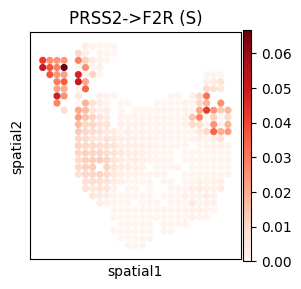

In [17]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.spatial(CCCProb.adata, spot_size=1, color="PRSS2->F2R (S)", cmap='Reds', img_key=None)

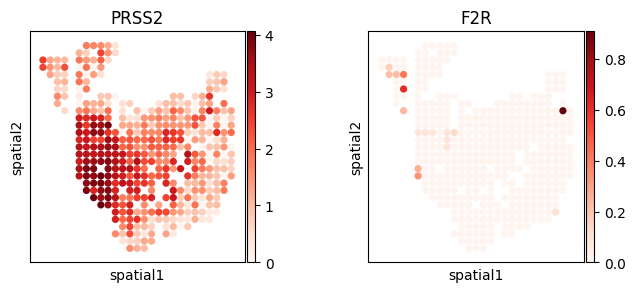

In [18]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.spatial(CCCProb.adata, spot_size=1, color=["PRSS2", "F2R"], cmap='Reds', img_key=None)

## Cell-group level results

In [21]:
from models.help_func import aggregate_to_group

cell_to_group = adata.obs['cell_type'].to_dict()
group_result = {}
for lr_key, matrix in res_dict.items():
    group_matrix = aggregate_to_group(matrix, cell_to_group)
    group_result[lr_key] = group_matrix.values